# Machine Translation

## [Task 1] Run Machine Translation and Code Reading

<br />

I am going to run an official sample code on Keras for machine translation from English to French.


https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Download files

from google.colab import files

files = files.upload()
file_name = list(files.keys())[0]
file_string = files[file_name].decode()

file_string

Output hidden; open in https://colab.research.google.com to view.

In [0]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 25  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])

    print('Decoded sentence:', decoded_sentence)

Using TensorFlow backend.


Number of samples: 10000
Number of unique input tokens: 69
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 8000 samples, validate on 2000 samples
Epoch 1/25
8000/8000 [==============================] - 21s 3ms/step - loss: 0.9183 - val_loss: 0.9568
Epoch 2/25
8000/8000 [==============================] - 17s 2ms/step - loss: 0.7259 - val_loss: 0.7683
Epoch 3/25
8000/8000 [==============================] - 17s 2ms/step - loss: 0.6157 - val_loss: 0.6943
Epoch 4/25
8000/8000 [==============================] - 17s 2ms/step - loss: 0.5614 - val_loss: 0.6412
Epoch 5/25
8000/8000 [==============================] - 17s 2ms/step - loss: 0.5211 - val_loss: 0.5999
Epoch 6/25
8000/8000 [==============================] - 17s 2ms/step - los

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


-
Input sentence: Go.
Decoded sentence: Parsonnez-vous !

-
Input sentence: Hi.
Decoded sentence: Sontez de l'air !

-
Input sentence: Run!
Decoded sentence: Sais-toi de vot !

-
Input sentence: Run!
Decoded sentence: Sais-toi de vot !

-
Input sentence: Wow!
Decoded sentence: Attendez !

-
Input sentence: Fire!
Decoded sentence: Attendez ici.

-
Input sentence: Help!
Decoded sentence: Salut !

-
Input sentence: Jump.
Decoded sentence: Va chercher ton ense.

-
Input sentence: Stop!
Decoded sentence: Arrête de tu la plise !

-
Input sentence: Stop!
Decoded sentence: Arrête de tu la plise !

-
Input sentence: Stop!
Decoded sentence: Arrête de tu la plise !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Go on.
Decoded sentence: Va là chercher !

-
Input sentence: Go on.
Decoded sentence: Va là chercher !

-
Input sentence: Go on.
Decoded sentence: Va là chercher !

-
Input sentence: Hello!
Decoded sentence: Sa

### Code Reading

<br />

    - 52~56 Import libraries
    
    - 58~61 Set hyperparameters
    
    - 62~63 Set a path to a dataset file
    
    - 65~84 Vectorize the data
    
    - 99~102 Create dictionaries to associate inputs and targets with their own indices
    
    - 104~112 Prepare arrays for saving datas
    
    - 114~123 One hot encoder
    
    - 125~130 Set a model of LSTM mapping inputs to vectors whose lengths are fixed
    
    - 132~141 Set a model of LSTM decoding targets from the vectors
    
    - 143~154 Define the whole model and run
    
    - 164~176 Define a model using functional API
    
    - 178~183 Reverse-lookup token index to decode sequences back to something readable
    
    - 186~221 A definition for decoding sequences
    
    - 224~231 Show results

# Image Captioning

<br />

I am going to implement sample codes on PyTorch for image captioning.


https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

## [Task 2] Run Pretrained Model of Image Captioning

#### Clone the Repositories

In [0]:
!git clone https://github.com/pdollar/coco.git

Cloning into 'coco'...
remote: Enumerating objects: 947, done.
remote: Total 947 (delta 0), reused 0 (delta 0), pack-reused 947
Receiving objects: 100% (947/947), 11.69 MiB | 5.30 MiB/s, done.
Resolving deltas: 100% (564/564), done.


In [0]:
cd coco/PythonAPI/

/content/coco/PythonAPI


In [0]:
!make

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:

In [0]:
!python setup.py build

running build
running build_py
creating build
creating build/lib.linux-x86_64-3.6
creating build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/coco.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/mask.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/cocoeval.py -> build/lib.linux-x86_64-3.6/pycocotools
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-func

In [0]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating pycocotools.egg-info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/coco.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/_mask.cpython-36m-x86_64-linux-gnu.so -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__

In [0]:
cd ../../

/content


In [0]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 813, done.
remote: Total 813 (delta 0), reused 0 (delta 0), pack-reused 813
Receiving objects: 100% (813/813), 12.78 MiB | 5.78 MiB/s, done.
Resolving deltas: 100% (430/430), done.


In [0]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


#### Test the Model

In [0]:
# Download pretrained models

!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0

--2019-03-31 04:41:58--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [following]
--2019-03-31 04:41:58--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc62eaf40f4c4c6db2935766490f.dl.dropboxusercontent.com/cd/0/inline/AeGHn0dhzxGeD1pnoBbCrMDB7WdnyWncBXiiqpgqAe8LP32km-TvwvfOrLuEXRuY5ee4URDiiFE211_9O4iseUW96TVANOAQLPkCDzAhKg_uryh0G9cLmiR8xZJ2dNs0WPs/file# [following]
--2019-03-31 04:41:59--  https://uc62eaf40f4c4c6db2935766490f.dl.dropboxusercontent.com/cd/0/inline/AeGHn0dhzxGeD1pnoBbCrMDB7WdnyWncBXiiqpgqAe8LP32km-TvwvfOrLuEXRuY5ee4URDiiFE211_9O4

In [0]:
# Unzip the files

!unzip pretrained_model.zip?dl=0

Archive:  pretrained_model.zip?dl=0
  inflating: encoder-5-3000.pkl      
  inflating: decoder-5-3000.pkl      


In [0]:
# Rename

!mv encoder-5-3000.pkl encoder-2-1000.ckpt
!mv decoder-5-3000.pkl decoder-2-1000.ckpt

In [0]:
# Move them to "models" directory

!mkdir models
!mv encoder-2-1000.ckpt models
!mv decoder-2-1000.ckpt models

In [0]:
# Download a vocabulary file

!wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0

--2019-03-31 04:43:23--  https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/26adb7y9m98uisa/vocap.zip [following]
--2019-03-31 04:43:24--  https://www.dropbox.com/s/raw/26adb7y9m98uisa/vocap.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc783cd8c831987e6d65edf75d9f.dl.dropboxusercontent.com/cd/0/inline/AeG2gl-wmAmJFzea25vK16E7ysDatRmXOrPmY2fvMltp8If_NW8sXMwew0VNwGnfeHbtIFoWUtZfTsST7wmeeHN7pNWc5vvOuGUc-daPmnJ9-bJGT2oo70hqNtaa4eMT_6o/file# [following]
--2019-03-31 04:43:24--  https://uc783cd8c831987e6d65edf75d9f.dl.dropboxusercontent.com/cd/0/inline/AeG2gl-wmAmJFzea25vK16E7ysDatRmXOrPmY2fvMltp8If_NW8sXMwew0VNwGnfeHbtIFoWUtZfTsST7wmeeHN7pNWc5vvOuGUc-daPmnJ9-bJGT2o

In [0]:
# Unzip the file

!unzip vocap.zip?dl=0

Archive:  vocap.zip?dl=0
  inflating: vocab.pkl               


In [0]:
# Move it to "data" directory

!mkdir data
!mv vocab.pkl data

#### Test the Model

#### 1st Try

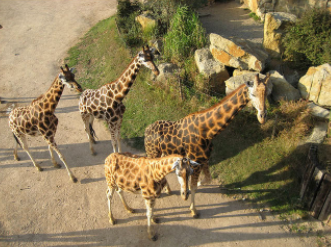

In [0]:
# Check an example image

from IPython.display import Image,display_png
display_png(Image('png/example.png'))

In [0]:
# Test the model by using a prepared image

!python sample.py --image='png/example.png'

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
241530880it [00:02, 89008722.84it/s]
<start> a group of giraffes standing next to each other . <end>


#### 2nd Try

In [0]:
# Download a free image from a website

!wget https://www.pakutaso.com/shared/img/thumb/datumouFTHG7300_TP_V.jpg

--2019-03-31 04:44:39--  https://www.pakutaso.com/shared/img/thumb/datumouFTHG7300_TP_V.jpg
Resolving www.pakutaso.com (www.pakutaso.com)... 180.235.251.31
Connecting to www.pakutaso.com (www.pakutaso.com)|180.235.251.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114978 (112K) [image/jpeg]
Saving to: ‘datumouFTHG7300_TP_V.jpg’

datumouFTHG7300_TP_ 100%[===================>] 112.28K  --.-KB/s    in 0.07s   

2019-03-31 04:44:39 (1.53 MB/s) - ‘datumouFTHG7300_TP_V.jpg’ saved [114978/114978]



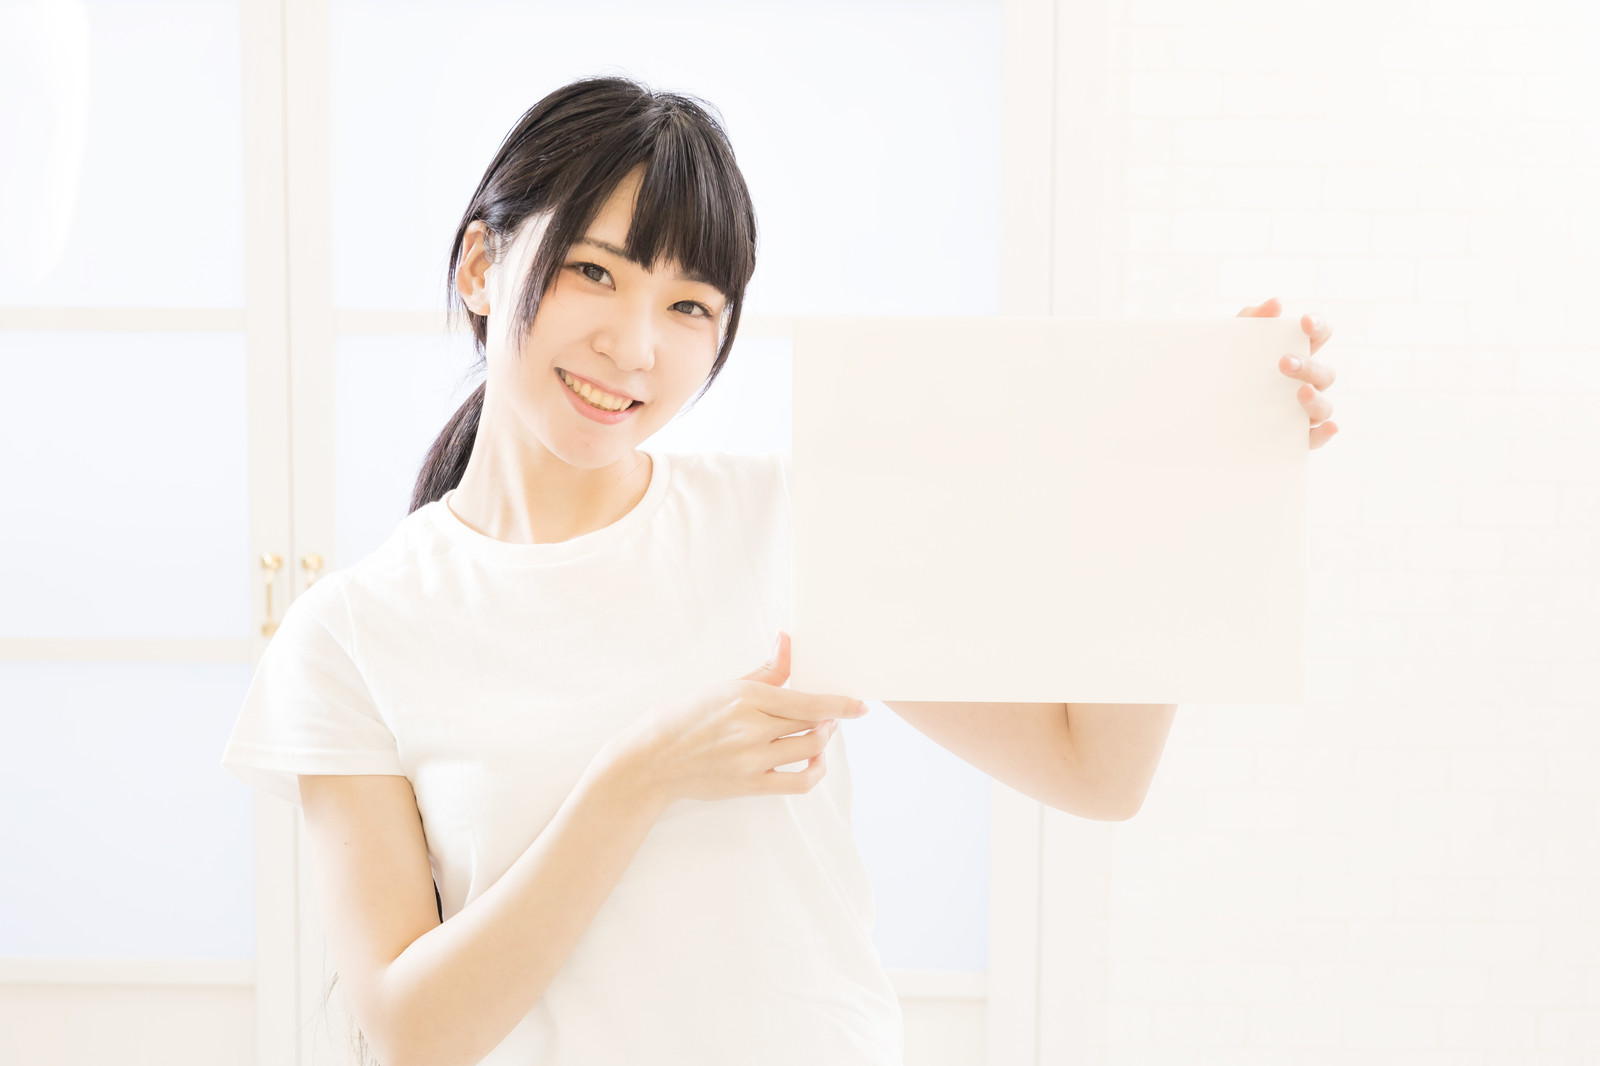

In [0]:
# Display the image

from IPython.display import Image,display_jpeg
display_jpeg(Image('datumouFTHG7300_TP_V.jpg'))

In [0]:
# Test the model

!python sample.py --image='datumouFTHG7300_TP_V.jpg'

<start> a woman in a dress shirt and a tie . <end>


#### 3rd Try

In [0]:
# Download my own image

from google.colab import files
uploaded = files.upload()

Saving IMG_0339.jpg to IMG_0339.jpg


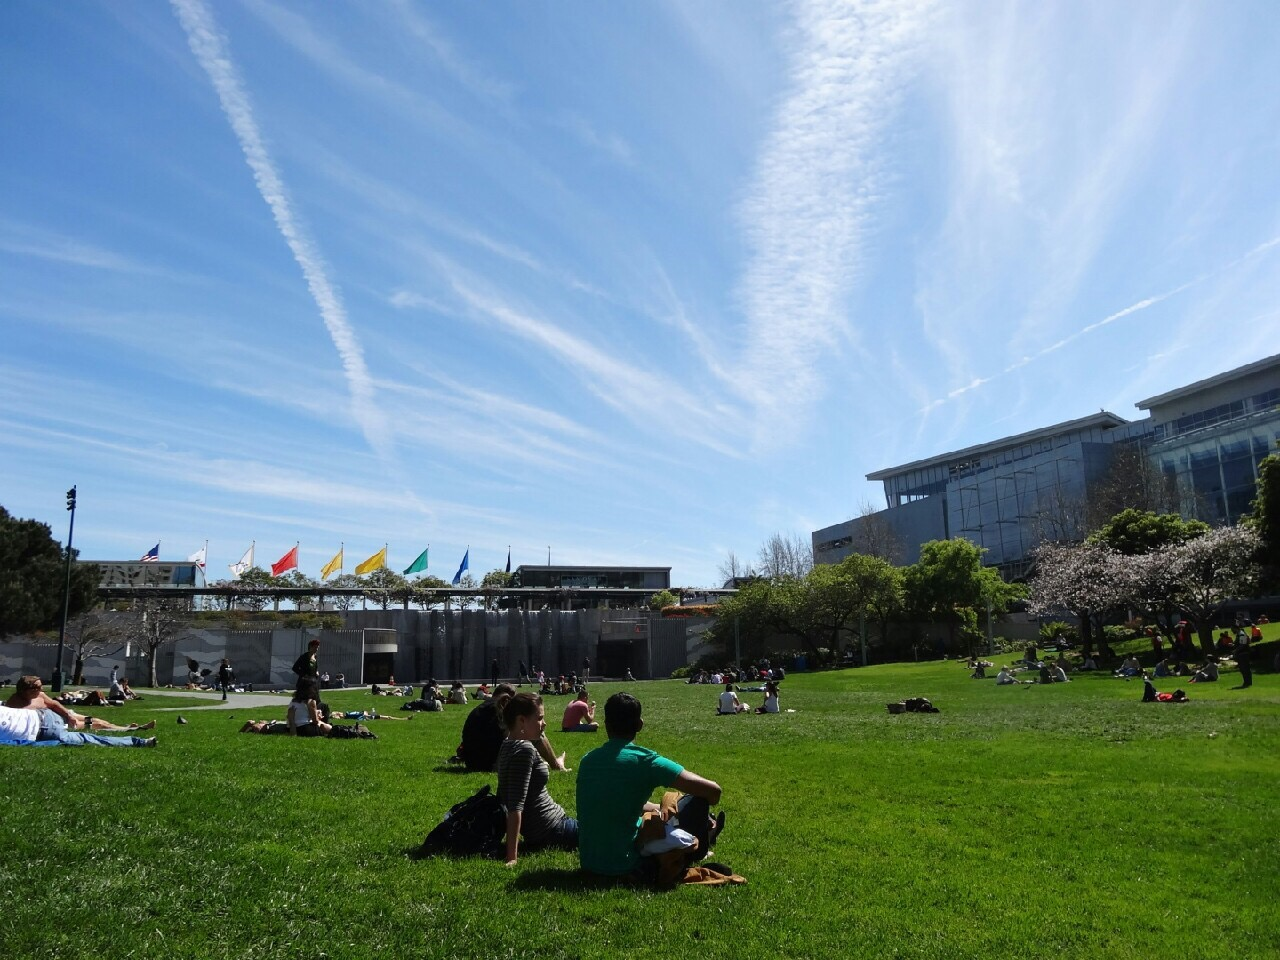

In [0]:
# Display the image

from IPython.display import Image,display_jpeg
display_jpeg(Image('IMG_0339.jpg'))

In [0]:
# Test the model

!python sample.py --image='IMG_0339.jpg'

<start> a group of people playing a game of frisbee . <end>


## [Task 3] Research How to Run the Implementation on the Other Framework like Keras

It is necessary to

    - Create a model on Keras for image captioning
    
    - Change the form of the weight trained on PyTorch to a form for Keras

## [Task 4] Code Reading and Rewrite

<br />

I am going to rewite codes of "model.py" for implementations on Keras.


https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning/model.py